# **IMAGE AUTO ENCODER USING SUPERVISED EFOREST ON CIFAR-10 WITH 500 TREE**

In [ ]:
import copy
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


### **DEFINE NODE RULE**

In [ ]:
class NodeRule:

    LT = 0 # 'less than'
    LE = 1 # 'less or equal to'

    def __init__(self, attribute, threshold, op):
        # [lower_bound] [op_left] value [op_right] [upper_bound]
        assert(op in ['gt', 'le'])
        self.attribute = attribute
        if op == 'le':
            self.lower_bound = -np.inf
            self.upper_bound = threshold
            self.op_left = NodeRule.LT
            self.op_right = NodeRule.LE
        else:
            self.lower_bound = threshold
            self.upper_bound = np.inf
            self.op_left = NodeRule.LT
            self.op_right = NodeRule.LT
    
    def __and__(self, other):
        new_rule = copy.copy(self)
        if self.lower_bound > other.lower_bound:
            new_rule.lower_bound = self.lower_bound
            new_rule.op_left = self.op_left
        elif self.lower_bound < other.lower_bound:
            new_rule.lower_bound = other.lower_bound
            new_rule.op_left = other.op_left
        else:
            new_rule.lower_bound = self.lower_bound
            if NodeRule.LT in [self.op_left, other.op_left]:
                new_rule.op_left = NodeRule.LT
            else:
                new_rule.op_left = NodeRule.LE
        if self.upper_bound < other.upper_bound:
            new_rule.upper_bound = self.upper_bound
            new_rule.op_right = self.op_right
        elif self.upper_bound > other.upper_bound:
            new_rule.upper_bound = other.upper_bound
            new_rule.op_right = other.op_right
        else:
            new_rule.upper_bound = self.upper_bound
            if NodeRule.LT in [self.op_right, other.op_right]:
                new_rule.op_right = NodeRule.LT
            else:
                new_rule.op_right = NodeRule.LE
        return new_rule

    def __str__(self):
        s = str(self.lower_bound) + ' '
        s += '<=' if self.op_left == NodeRule.LE else '<'
        s += ' x_%i ' % self.attribute
        s += '<=' if self.op_right == NodeRule.LE else '<'
        s += ' ' + str(self.upper_bound)
        return s
    
    def __repr__(self):
        return self.__str__()

### **DEFINE PATH RULE**

In [ ]:
class PathRule:
    
    def __init__(self, n_attributes):
        self.n_attributes = n_attributes
        self.node_rules = [NodeRule(i, -np.inf, 'gt') for i in range(n_attributes)]
    
    def set_global_bounds(self, lower_bounds, upper_bounds):
        for i in range(self.n_attributes):
            node_rule = NodeRule(i, -np.inf, 'gt')
            node_rule.op_left = NodeRule.LE
            node_rule.op_right = NodeRule.LE
            node_rule.lower_bound = lower_bounds[i]
            node_rule.upper_bound = upper_bounds[i]
            self.add(node_rule)
    
    def add(self, node_rule):
        assert(isinstance(node_rule, NodeRule))
        j = node_rule.attribute
        self.node_rules[j] = self.node_rules[j].__and__(node_rule)
    
    def sample(self, sampling='mean'):
        sample = np.empty(self.n_attributes)
        for i, rule in enumerate(self):
            if sampling == 'mean':
                sample[i] = (rule.lower_bound + rule.upper_bound) / 2.
            else:
                sample[i] = np.random.uniform(rule.lower_bound, rule.upper_bound)
        return sample
    
    def compute_volume(self):
        log_volume = 1
        for i in range(self.n_attributes):
            node_rule = self.node_rules[i]
            log_volume += (node_rule.upper_bound - node_rule.lower_bound)
            assert(node_rule.upper_bound >= node_rule.lower_bound)
        return log_volume
    
    def __len__(self):
        return len(self.node_rules)
    
    def __iter__(self):
        self.current_attribute = 0
        return self
    
    def __next__(self):
        self.current_attribute += 1
        try:
            result = self.node_rules[self.current_attribute-1]
        except IndexError:
            raise StopIteration
        return result
    
    def __str__(self):
        return str(self.node_rules)
    
    def __repr__(self):
        return self.__str__()

## **RANDOME TREE MODEL**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from sklearn.tree import ExtraTreeRegressor

In [ ]:
class CompletelyRandomTree:

    def __init__(self, sklearn_extra_tree, n_attributes):
        self.n_attributes = n_attributes
        self.tree = sklearn_extra_tree
        self.n_nodes = self.tree.tree_.node_count
        self.parent_ids = np.full(self.n_nodes, -1, dtype=np.int)
        self.operators = [None] * self.n_nodes
        tree = self.tree.tree_
        for i in range(self.n_nodes):
            parent_from_left = np.where(tree.children_left == i)[0]
            parent_from_right = np.where(tree.children_right == i)[0]
            if len(parent_from_left) == 1:
                self.parent_ids[i] = parent_from_left[0]
                self.operators[i] = 'le'
            elif len(parent_from_right) == 1:
                self.parent_ids[i] = parent_from_right[0]
                self.operators[i] = 'gt'
        self.leaf_to_node = np.where(tree.feature == -2)[0]
        self.node_to_leaf = {node_id: leaf_id for leaf_id, node_id in enumerate(self.leaf_to_node)}
        self.n_leafs = len(self.leaf_to_node)
    
    def encode(self, X):
        node_ids = self.tree.apply(X)
        return [self.node_to_leaf[node_id] for node_id in node_ids]
    
    def get_path_rule(self, default_path_rule, leaf_id):
        path_rule = copy.deepcopy(default_path_rule)
        tree = self.tree.tree_
        current_id = self.leaf_to_node[leaf_id]
        while current_id != 0:
            attribute = tree.feature[self.parent_ids[current_id]]
            bound = tree.threshold[self.parent_ids[current_id]]
            op = self.operators[current_id]
            path_rule.add(NodeRule(attribute, bound, op))
            current_id = self.parent_ids[current_id]
        return path_rule


## **DEFINE ENCODER FOREST**

In [ ]:
class EncoderForest:

    def __init__(self, n_components):
        self.trees = list()
        self.n_attributes = 0
        self.in_size = 0
        self.out_size = n_components
        self.global_lower_bounds = None
        self.global_upper_bounds = None
        self.default_path_rule = None
        self.unsupervised = True
    
    def fit(self, X, y=None, max_depth=10):
        self.unsupervised = (y is None)
        self.n_attributes = X.shape[1]
        self.in_size = X.shape[0]
        if y is None:
            forest = RandomTreesEmbedding(self.out_size, max_depth=max_depth)
            forest.fit(X)
        else:
            forest = RandomForestClassifier(n_estimators=self.out_size, max_depth=max_depth)
            forest.fit(X, y)
        for i in range(self.out_size):
            self.trees.append(CompletelyRandomTree(forest.estimators_[i], self.n_attributes))
        
        self.global_lower_bounds = np.min(X, axis=0).astype(np.double)
        self.global_upper_bounds = np.max(X, axis=0).astype(np.double)

        self.default_path_rule = PathRule(self.n_attributes)
        self.default_path_rule.set_global_bounds(self.global_lower_bounds, self.global_upper_bounds)
    
    def encode(self, X):
        n_samples = X.shape[0]
        out_dim = len(self.trees)
        encoded = np.empty((n_samples, out_dim), dtype=np.int)
        for i in range(out_dim):
            encoded[:, i] = self.trees[i].encode(X)
        return encoded

    def compute_rule_list(self, x):
        out_dim = len(self.trees)
        rule_list = list()
        for i in range(out_dim):
            path_rule = self.trees[i].get_path_rule(self.default_path_rule, x[i])
            rule_list.append(path_rule)
        return rule_list
    
    def decode(self, x):
        rule_list = self.compute_rule_list(x)
        MCR = self.calculate_MCR(rule_list)
        return MCR.sample(sampling='mean')

    def calculate_MCR(self, path_rule_list):
        MCR = copy.deepcopy(self.default_path_rule)
        n_attributes = len(MCR)
        n_trees = len(path_rule_list)

        for i in range(len(path_rule_list)):
            path_rule = path_rule_list[i]
            print("Volume of path rule %i: %f" % (i, path_rule.compute_volume()))
            for node_rule in path_rule.node_rules:
                MCR.add(node_rule)
        print("Volume of MCR: %f" % MCR.compute_volume())
        return MCR

### **MODEL EVALUATION**

In [ ]:
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt

In [ ]:
keras.backend.set_image_data_format("channels_last")

In [ ]:
#args = parse_args()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape[-1] == 3
assert x_test.shape[-1] == 3
x_train = x_train.reshape((x_train.shape[0], -1, 3))
x_test = x_test.reshape((x_test.shape[0], -1, 3))
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

[cifar] x_train.shape=(50000, 1024, 3), y_train.shape=(50000,)
[cifar] x_test.shape=(10000, 1024, 3), y_test.shape=(10000,)


In [ ]:
test_images = np.zeros((10, 32 * 32, 3))
for label in range(10):
    index = np.where(y_test == label)[0][0]
    test_images[label] = x_test[index]


In [ ]:
print(test_images[:,:,1])

[[156. 176. 179. ...  63.  65.  68.]
 [ 37.  49.  57. ...  28.  32.  30.]
 [103.  91. 162. ...  91. 114. 121.]
 ...
 [ 36.  64.  41. ...   7.   4.   4.]
 [235. 231. 232. ... 183. 195. 200.]
 [255. 253. 252. ... 163. 170. 176.]]


In [ ]:
# the autoencoder results
results = np.zeros((10, 32 * 32, 3))

In [ ]:
from keras.callbacks import ModelCheckpoint   
import time

start = time.time() # for stopwatch
print("Start Autoencoder using model")
encoder_channels = []
# if model == "unsupervised":
# for c in range(3):        
#eforest = RandomForestClassifier(n_estimators=n_trees, max_depth=None, n_jobs=-1, random_state=0)
for c in range(3):
    encoder = EncoderForest(500)
    encoder.fit(x_train[:,:,c], y_train, max_depth=5)
    encoder_channels.append(encoder)
print("end fit on supervised model")
end = time.time()
took = end - start

Start Autoencoder using model
end fit on supervised model


In [ ]:
print("took %s seconds"%(took))

took 587.8630011081696 seconds


In [ ]:
start = time.time() # for stopwatch     
for i in range(3): 
    x_encode = encoder.encode(test_images[:,:,i])
    for a in range(10):
        #for i in range(3):
        x_decode = encoder.decode(x_encode[a])
        results[a,:,i]=x_decode
end = time.time()
took = end - start

Streaming output truncated to the last 5000 lines.
Volume of path rule 10: 260485.500000
Volume of path rule 11: 260453.500000
Volume of path rule 12: 260443.500000
Volume of path rule 13: 260498.500000
Volume of path rule 14: 260507.500000
Volume of path rule 15: 260480.500000
Volume of path rule 16: 260463.500000
Volume of path rule 17: 260604.500000
Volume of path rule 18: 260495.500000
Volume of path rule 19: 260471.500000
Volume of path rule 20: 260477.500000
Volume of path rule 21: 260446.500000
Volume of path rule 22: 260476.500000
Volume of path rule 23: 260466.500000
Volume of path rule 24: 260475.500000
Volume of path rule 25: 260484.500000
Volume of path rule 26: 260449.500000
Volume of path rule 27: 260669.500000
Volume of path rule 28: 260507.500000
Volume of path rule 29: 260442.500000
Volume of path rule 30: 260531.500000
Volume of path rule 31: 260470.500000
Volume of path rule 32: 260437.500000
Volume of path rule 33: 260424.500000
Volume of path rule 34: 260617.500000

In [ ]:
print("took %s seconds"%(took))

took 361.7535367012024 seconds


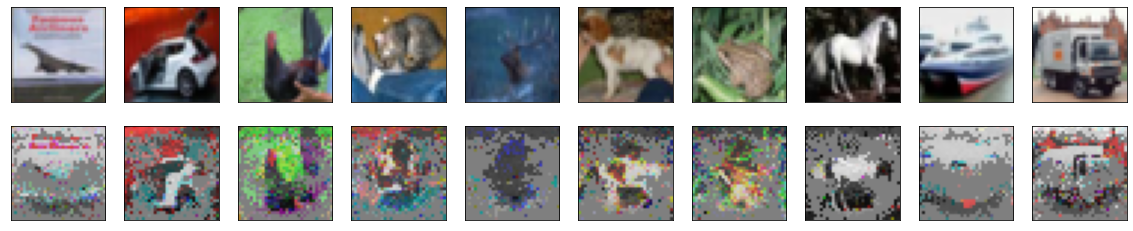

In [27]:
test_images = test_images.reshape(1, 10, 32, 32, 3).astype(np.uint8)
results = results.reshape(1, 10, 32, 32, 3).astype(np.uint8)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #Convert test image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_images[0,i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #How many items to display
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(results[0,i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##**MEAN SQUARE ERROR**

In [ ]:
from sklearn.metrics import mean_squared_error

X_true = test_images.reshape(10,3072)
X_pred = results.reshape(10,3072)

mse = mean_squared_error(X_true, X_pred)
mse 

102.13440755208335